In [32]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import gym
from procgen import ProcgenEnv
import matplotlib.pyplot as plt
from itertools import chain
from tqdm.auto import tqdm
device = 'mps'

In [33]:
# Converts vanilla procgen env into something much better

class ProcgenWrapper(gym.Wrapper):
    def __init__(self, env):
        # env = gym.wrappers.TransformObservation(env, lambda obs: obs["rgb"])
        super().__init__(env)

        self.single_action_space = env.action_space
        self.action_space = gym.spaces.MultiDiscrete([self.single_action_space.n] * self.num_envs)
        self.single_observation_space = env.observation_space["rgb"]
        self.observation_space = None  # TODO implement this
        self.is_vector_env = True
        self.action_meanings = ["leftdown", "left", "leftup", "down", "noop", "up", "rightdown", "right", "rightup", "d", "a", "w", "s", "q", "e"]

    def reset(self):
        obs = self.env.reset()
        obs = obs["rgb"]
        return obs, {}

    def step(self, action):
        obs, rew, done, infos = self.env.step(action)
        obs = obs["rgb"]
        return obs, rew, done, {}

# Only actions that are up, down, left, right, noop

class OrdinalActions(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

        am_udlr = ["noop", "up", "down", "left", "right"]
        
        self.i_actions = np.array([i for i, am in enumerate(self.action_meanings) if am in am_udlr])
        self.action_meanings = [self.action_meanings[i] for i in self.i_actions]
        self.single_action_space = gym.spaces.Discrete(len(self.action_meanings))
        self.action_space = gym.spaces.MultiDiscrete([self.single_action_space.n] * self.num_envs)

    def step(self, action):
        action = self.i_actions[action]
        obs, rew, done, info = self.env.step(action)
        return obs, rew, done, info

def collect_rollouts(n_envs=64, n_steps=128, ordinal_actions=True):
    env = ProcgenEnv(n_envs, "miner", distribution_mode="hard", num_levels=0, start_level=0)
    env = ProcgenWrapper(env)
    if ordinal_actions:
        env = OrdinalActions(env)
    obs, info = env.reset()
    obss, actions = [obs], []

    for i in range(n_steps):
        action = env.action_space.sample()
        obs, rew, done, info = env.step(action)
        obss.append(obs)
        actions.append(action)
    obss = np.stack(obss)

    actions = np.stack(actions)
    obs_now, obs_nxt, action_now = obss[:-1], obss[1:], actions

    # obs_now    is the observation at current timestep. shape: (n_steps, n_envs, 64, 64, 3), dtype: uint8, range: [0, 255]
    # obs_nxt    is the observation at    next timestep. shape: (n_steps, n_envs, 64, 64, 3), dtype: uint8, range: [0, 255]
    # action_now is the      action at current timestep. shape: (n_steps, n_envs,          ), dtype: uint8, range: [0,  15]

    return env, obs_now, obs_nxt, action_now

In [35]:
n_envs, n_steps = 256, 128

curr_obs = []
next_obs = []
action = []
for _ in tqdm(range(200)):
    env, obs_now, obs_nxt, action_now = collect_rollouts(n_envs, n_steps, ordinal_actions=True)
    indices = np.random.choice(128,20)
    curr_obs.append(obs_now[indices, :, :, :, :])
    next_obs.append(obs_nxt[indices, :, :, :, :])
    action.append(action_now[indices,:])

curr_obs = np.stack(curr_obs).reshape(-1, 64, 64, 3)
next_obs = np.stack(next_obs).reshape(-1, 64, 64, 3)
action = np.stack(action).reshape(-1, 1)


  0%|          | 0/200 [00:00<?, ?it/s]

'left'

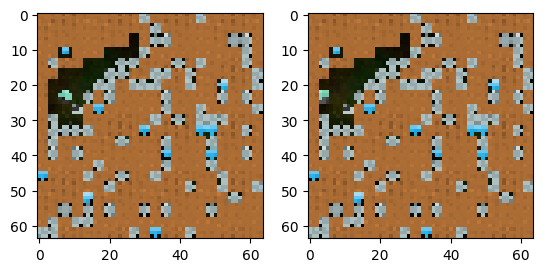

In [36]:
plt.subplot(121)
plt.imshow(curr_obs[-1009])
plt.subplot(122)
plt.imshow(next_obs[-1009])
env.action_meanings[action[-1009].item()]

In [37]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(12544, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        output = self.fc1(x)
        return output

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(128+128, 128)
        self.fc2 = nn.Linear(128, 5)
        

    def forward(self, enc1 ,enc2):
        x = torch.concat([enc1, enc2], dim=-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=-1)
        return output

In [ ]:
phi = Encoder().to(device)
head = Net().to(device)
data = np.stack([curr_obs, next_obs], axis=-1)

dataset = TensorDataset(torch.tensor(data, dtype=torch.float32),torch.tensor(action, dtype=torch.int64))
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
# data = torch.tensor(curr_obs[0,:,:,:], dtype=torch.float32).unsqueeze(dim=0)
# data = data.permute(0, 3, 1, 2).to(device)

optimizer = optim.Adam(chain(phi.parameters(), head.parameters()), lr=3e-4)

In [ ]:
device

In [29]:
losses = []
accuracies = []
for epoch in range(20):
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        current_obs_data =  data[:,:,:,:,0]
        next_obs_data =  data[:,:,:,:,1]
        optimizer.zero_grad()
        latent1 = phi(current_obs_data.permute(0, 3, 1, 2))
        latent2 = phi(next_obs_data.permute(0, 3, 1, 2))
        output = head(latent1, latent2)
        target = target.squeeze()
        with torch.no_grad():
            _, indices = torch.max(torch.exp(output), dim=-1)
            acc = np.mean((indices == target).cpu().numpy())
        loss = F.nll_loss(output, target)
        loss.backward()
        losses.append(loss.item())
        accuracies.append(acc)
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item()))

Train Epoch: 0 [0/64000 (0%)]	Loss: 2.004038
Train Epoch: 0 [6400/64000 (10%)]	Loss: 1.612178
Train Epoch: 0 [12800/64000 (20%)]	Loss: 1.609458
Train Epoch: 0 [19200/64000 (30%)]	Loss: 1.607605
Train Epoch: 0 [25600/64000 (40%)]	Loss: 1.609080
Train Epoch: 0 [32000/64000 (50%)]	Loss: 1.608267
Train Epoch: 0 [38400/64000 (60%)]	Loss: 1.612462
Train Epoch: 0 [44800/64000 (70%)]	Loss: 1.608238
Train Epoch: 0 [51200/64000 (80%)]	Loss: 1.611270
Train Epoch: 0 [57600/64000 (90%)]	Loss: 1.609072
Train Epoch: 1 [0/64000 (0%)]	Loss: 1.611293
Train Epoch: 1 [6400/64000 (10%)]	Loss: 1.612332
Train Epoch: 1 [12800/64000 (20%)]	Loss: 1.607539
Train Epoch: 1 [19200/64000 (30%)]	Loss: 1.606678
Train Epoch: 1 [25600/64000 (40%)]	Loss: 1.610599
Train Epoch: 1 [32000/64000 (50%)]	Loss: 1.608783
Train Epoch: 1 [38400/64000 (60%)]	Loss: 1.597616
Train Epoch: 1 [44800/64000 (70%)]	Loss: 1.612602
Train Epoch: 1 [51200/64000 (80%)]	Loss: 1.608505
Train Epoch: 1 [57600/64000 (90%)]	Loss: 1.604308
Train Epoch:

KeyboardInterrupt: 

(0.0, 1.63)

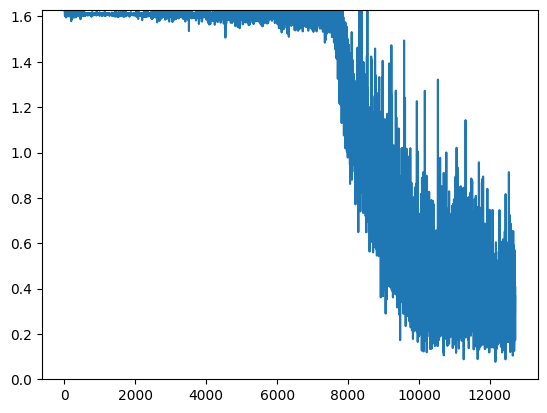

In [31]:
plt.plot(losses)
plt.ylim(0, 1.63)

In [47]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

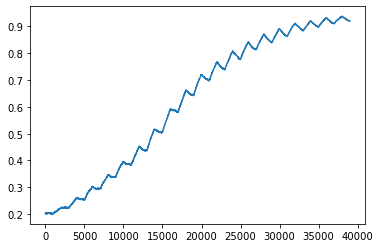

In [55]:
plt.plot(running_mean(accuracies, 1000))

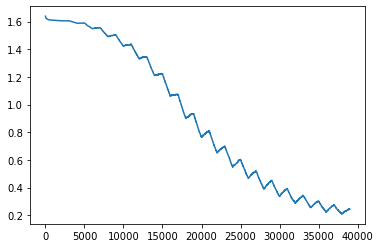

In [57]:
plt.plot(running_mean(losses, 1000))